# Inventario — Limpieza y EDA (v7 ordenado)

> Notebook organizado: solo se reetiquetaron títulos y numeración; **ningún código fue modificado**.

# 1. Limpieza básica — INV_2025

Este cuaderno aplica **tres pasos**, cada uno **en su propia celda** y **explicado**:
1) Convertir `cdate` y `odate` a formato de fecha.
2) Reemplazar `9999` por nulos en `year` (y en otras columnas tipo "year" si existen).
3) **Dropear filas con `ODATE` faltante y eliminar registros con fechas anteriores a 2017** (usando **ODATE** como referencia temporal).

> **Nota:** La primera celda de código sólo carga el dataset para ejecutar los pasos.

In [1]:

# Preparación: carga del dataset
import pandas as pd, numpy as np, re

# Ruta al CSV (coloca este notebook en la misma carpeta del CSV o ajusta la ruta)
dataset_path = "INV_2025.csv"
df = pd.read_csv(dataset_path)

print("Dimensiones:", df.shape)
display(df.head(5))
print("\nTipos iniciales:")
print(df.dtypes)


Dimensiones: (153501, 11)


,ACTION_NUMBER,MAKE,MODEL,YEAR,COMPONENT,MFG_NAME,ODATE,CDATE,CAMP_NO,SUBJECT,SUMMARY
0,AQ09001,CAPCEN,9005,9999.0,EXTERIOR LIGHTING,"AUTO PAW TRADING, INC.",20090326.0,20090706.0,06E027000,HID REPLACEMENT KIT RECALL CAMPAIGNS,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...
1,DP05005,FORD,E SERIES SUPER DUTY,2001.0,ENGINE AND ENGINE COOLING,Ford Motor Company,20050922.0,20060104.0,NaN,SPARK PLUG EJECTION FROM CYLINDER HEAD,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ..."
2,DP05005,FORD,MUSTANG GT,2000.0,ENGINE AND ENGINE COOLING,Ford Motor Company,20050922.0,20060104.0,NaN,SPARK PLUG EJECTION FROM CYLINDER HEAD,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ..."
3,AQ09001,EASTONE,9005-8K,9999.0,EXTERIOR LIGHTING:HEADLIGHTS,VEHICLE ENHANCEMENT SPECIALTY PRODUCTS,20090326.0,20090706.0,08E044000,HID REPLACEMENT KIT RECALL CAMPAIGNS,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...
4,AQ09001,EASTONE,9006-8K,9999.0,EXTERIOR LIGHTING,VEHICLE ENHANCEMENT SPECIALTY PRODUCTS,20090326.0,20090706.0,07E073000,HID REPLACEMENT KIT RECALL CAMPAIGNS,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...



Tipos iniciales:
ACTION_NUMBER     object
MAKE              object
MODEL             object
YEAR             float64
COMPONENT         object
MFG_NAME          object
ODATE            float64
CDATE            float64
CAMP_NO           object
SUBJECT           object
SUMMARY           object
dtype: object


# 2. Paso 0 — Estandarizar nombres de columnas

- Convierte todos los nombres a **mayúsculas** y sin espacios extremos.
- Asegura que `ODATE` y `CDATE` queden estandarizadas si existen.
- Esta estandarización simplifica el resto del pipeline (evita asserts fallidos por mayúsc/minúsc).

In [2]:
# Paso 0: Normalización de nombres de columnas (estándar en mayúsculas)
df.columns = [c.strip().upper() for c in df.columns]
# Asegurar alias clásicos si vinieron en minúsculas u otras variantes
cmap = {c.lower(): c for c in df.columns}
# Si por alguna razón hay 'odate' o 'cdate' en otro casing, ya quedaron como 'ODATE'/'CDATE' arriba.
# Solo reportamos qué columnas de fecha quedaron disponibles:
print("Columnas de fecha presentes:", [c for c in df.columns if c in ("ODATE", "CDATE")])

Columnas de fecha presentes: ['ODATE', 'CDATE']


## 2.1 Paso 1 — Convertir `cdate` y `odate` a formato de fecha

- Detección **case-insensitive** de columnas `ODATE` y `CDATE`.
- Soporte robusto para fechas almacenadas como **YYYYMMDD** (incluyendo valores como `20090326.0`).
- Estrategia:
  1) **Extraer** la primera secuencia de **8 dígitos** (`YYYYMMDD`) si existe.
  2) Parsear con `format='%Y%m%d'`.
  3) Para el resto, usar `pd.to_datetime(..., dayfirst=True, errors='coerce')` como respaldo.

In [3]:
# Paso 1: conversión robusta a datetime usando captura de 8 dígitos (YYYYMMDD)
import re
col_map = {c.lower().strip(): c for c in df.columns}
odate_col = col_map.get("odate")
cdate_col = col_map.get("cdate")

def robust_parse_date(series):
    s = series.astype("string")
    eight = s.str.extract(r"(\d{8})", expand=False)
    parsed = pd.to_datetime(eight, format="%Y%m%d", errors="coerce")
    fallback_mask = parsed.isna()
    if fallback_mask.any():
        parsed.loc[fallback_mask] = pd.to_datetime(s[fallback_mask], dayfirst=True, errors="coerce")
    return parsed

converted_cols = []
for key in ["odate", "cdate"]:
    col = col_map.get(key)
    if col is None:
        continue
    before_nulls = int(df[col].isna().sum())
    parsed = robust_parse_date(df[col])
    df[col] = parsed
    after_nulls = int(df[col].isna().sum())
    converted_cols.append((col, before_nulls, after_nulls, str(df[col].dtype)))

print("Columnas convertidas a fecha (col, nulos_antes, nulos_despues, dtype):")
for info in converted_cols:
    print("  - ", info)

if odate_col is not None:
    print("Rango de ODATE tras conversión:")
    print("  min:", df[odate_col].min(), "| max:", df[odate_col].max())
    display(df[[odate_col]].head(5))
else:
    print("No se encontraron columnas cdate/odate.")


Columnas convertidas a fecha (col, nulos_antes, nulos_despues, dtype):
  -  ('ODATE', 157, 157, 'datetime64[ns]')
  -  ('CDATE', 75625, 75625, 'datetime64[ns]')
Rango de ODATE tras conversión:
  min: 1972-03-10 00:00:00 | max: 2025-09-15 00:00:00


,ODATE
0,2009-03-26
1,2005-09-22
2,2005-09-22
3,2009-03-26
4,2009-03-26



## 2.2 Paso 2 — Reemplazar valores `9999` por nulos en `year` (y columnas tipo año)

- Identificamos columnas cuyo nombre contenga **`year`** (por ejemplo `year`, `model_year`).
- Convertimos a numérico con `errors="coerce"` y reemplazamos `9999` → `NaN`.
- Reportamos otras columnas que aún contengan `9999` para revisión manual.

In [4]:

# Paso 2: 9999 -> NaN en columnas de año
import numpy as np

# Columna(s) tipo 'year' (case-insensitive)
year_like = []
for c in df.columns:
    if re.search(r'(?:^|_)years?$', c, flags=re.IGNORECASE) or re.search(r'year', c, flags=re.IGNORECASE):
        year_like.append(c)

replaced_counts = {}
replaced_counts_pct = {}
for c in year_like:
    # Convertimos a numérico para ubicar 9999; valores no numéricos -> NaN
    s = pd.to_numeric(df[c], errors="coerce")
    mask_9999 = s == 9999
    cnt = int(mask_9999.sum())
    replaced_counts[c] = cnt
    replaced_counts_pct[c] = (cnt / len(df)) * 100 if len(df) else 0.0
    s = s.mask(mask_9999, np.nan)
    df[c] = s

print("Reemplazos 9999 -> NaN por columna:", replaced_counts)
print("% de filas con 9999 por columna (antes del reemplazo):", {k: f"{v:.2f}%" for k,v in replaced_counts_pct.items()})

# Reporte de otras columnas con 9999 (no se reemplazan automáticamente)
cols_with_9999 = []
for c in df.columns:
    # Intentar detectar 9999 tanto en numérico como en texto
    try:
        s_num = pd.to_numeric(df[c], errors="coerce")
        cnt = int((s_num == 9999).sum())
        if cnt > 0 and c not in year_like:
            cols_with_9999.append((c, cnt))
    except Exception:
        # Si no es convertible, ignorar
        pass

if cols_with_9999:
    print("Otras columnas con 9999 (revise si son sentinelas y considere limpiarlas):")
    for c, cnt in cols_with_9999:
        print(f"  - {c}: {cnt}")
else:
    print("No se detectaron otras columnas con el valor 9999.")


Reemplazos 9999 -> NaN por columna: {'YEAR': 6956}
% de filas con 9999 por columna (antes del reemplazo): {'YEAR': '4.53%'}
No se detectaron otras columnas con el valor 9999.


## 2.3 Paso 3 — Dropear `ODATE` faltante y filtrar por fecha (≥ 2017)

- Primero **eliminamos** filas donde `ODATE` esté vacío (`NaT` tras el Paso 1). Esto garantiza que todas las observaciones remanentes tengan fecha de apertura válida.
- Luego aplicamos un corte temporal con `cutoff = 2017-01-01` y conservamos únicamente registros con `ODATE >= cutoff`.
- Ya **no** usamos `CDATE` como respaldo: las filas **deben** tener `ODATE` válido para permanecer.

In [5]:
# Paso 3: eliminar ODATE faltante y filtrar por fecha >= 2017-01-01
cutoff = pd.Timestamp("2017-01-01")

# Localizamos la columna ODATE (case-insensitive)
col_map = {c.lower(): c for c in df.columns}
odate_col = col_map.get("odate")

if odate_col is None:
    raise ValueError("No se encontró la columna 'ODATE' para aplicar el filtro temporal y el drop de faltantes.")

# 1) Drop de ODATE faltante
initial_rows = len(df)
missing_before = int(df[odate_col].isna().sum())
df = df.loc[df[odate_col].notna()].copy()
after_drop_missing = len(df)
removed_missing = initial_rows - after_drop_missing

# 1b) CDATE faltante (no se elimina: casos abiertos)
if "CDATE" in df.columns:
    missing_c_before = int(df["CDATE"].isna().sum())
else:
    missing_c_before = 0

# 2) Filtro temporal por ODATE
before_time_filter = len(df)
df = df.loc[df[odate_col] >= cutoff].copy()
after_time_filter = len(df)
removed_early = before_time_filter - after_time_filter

print(
    f"ODATE faltante antes del drop: {missing_before} | "
    f"Filas eliminadas por ODATE faltante: {removed_missing}"
)
print(
    f"CDATE faltante actuales (no se eliminan; abiertos): {missing_c_before}"
)

# 1c) Drop de CAMPNO faltante (o alias equivalente)
camp_key = None
if "CAMPNO" in df.columns:
    camp_key = "CAMPNO"
else:
    # Resolver alias comunes: 'campno', 'camp_no', 'camp no' (ignorando '_' y espacios)
    cmap_alias = {col.lower().replace("_","").replace(" ",""): col for col in df.columns}
    if "campno" in cmap_alias:
        camp_key = cmap_alias["campno"]
if camp_key is not None:
    missing_cam_before = int(df[camp_key].isna().sum())
    before_cam_rows = len(df)
    df = df.loc[df[camp_key].notna()].copy()
    after_cam_rows = len(df)
    removed_cam_missing = before_cam_rows - after_cam_rows
    print(f"CAMPNO faltante antes del drop ({camp_key}): {missing_cam_before} | Filas eliminadas por CAMPNO faltante: {removed_cam_missing}")
else:
    print("CAMPNO no encontrado (ni alias). No se aplica drop por CAMPNO.")
print(
    f"Filas eliminadas por fecha < 2017-01-01: {removed_early} | "
    f"Filas finales: {after_time_filter}"
)
display(df.head(5))

# (Opcional) Guardar a disco: descomenta una de las líneas siguientes
# df.to_csv("INV_2025_clean.csv", index=False)
# df.to_parquet("INV_2025_clean.parquet", index=False)


ODATE faltante antes del drop: 157 | Filas eliminadas por ODATE faltante: 157
CDATE faltante actuales (no se eliminan; abiertos): 75469
CAMPNO faltante antes del drop (CAMP_NO): 7956 | Filas eliminadas por CAMPNO faltante: 7956
Filas eliminadas por fecha < 2017-01-01: 119107 | Filas finales: 34237


,ACTION_NUMBER,MAKE,MODEL,YEAR,COMPONENT,MFG_NAME,ODATE,CDATE,CAMP_NO,SUBJECT,SUMMARY
2661,DP18003,HYUNDAI,SANTA FE SPORT,2014.0,EXTERIOR LIGHTING:BRAKE LIGHTS:SWITCH,Hyundai Motor America,2018-08-21,2019-05-10,19V120000,Non-crash Vehicle Fires,"In a letter dated June 11, 2018, the Center fo..."
2662,DP18003,HYUNDAI,SANTA FE,2012.0,ELECTRICAL SYSTEM:12V/24V/48V BATTERY:CABLES,Hyundai Motor America,2018-08-21,2019-05-10,19V120000,Non-crash Vehicle Fires,"In a letter dated June 11, 2018, the Center fo..."
2663,DP18003,HYUNDAI,SONATA,2013.0,ENGINE AND ENGINE COOLING:EXHAUST SYSTEM:MANIF...,Hyundai Motor America,2018-08-21,2019-05-10,18V907000,Non-crash Vehicle Fires,"In a letter dated June 11, 2018, the Center fo..."
2664,DP18003,HYUNDAI,SANTA FE SPORT,2014.0,ENGINE AND ENGINE COOLING:EXHAUST SYSTEM:EMISS...,Hyundai Motor America,2018-08-21,2019-05-10,19V120000,Non-crash Vehicle Fires,"In a letter dated June 11, 2018, the Center fo..."
2665,DP18003,HYUNDAI,SANTA FE SPORT,2014.0,ELECTRICAL SYSTEM,Hyundai Motor America,2018-08-21,2019-05-10,19V120000,Non-crash Vehicle Fires,"In a letter dated June 11, 2018, the Center fo..."



## 2.4 Paso 4 — Reporte de faltantes por columna

**Objetivo:** cuantificar faltantes por columna tanto en sentido **estricto** (NA/NaN/NaT de pandas) como en sentido **ampliado** (*augmented*).

**Definición de faltante _augmented_:**
- Valores nulos estándar (`NaN`, `NaT`).
- Tokens tipo NA en texto: `""`, `"na"`, `"n/a"`, `"n\a"`, `"null"`, `"none"`, `"nan"`.
- **Sentinelas** numéricos: `9999` (común en columnas tipo `YEAR`).

**Entregables en esta celda:**
- Tabla con métricas por columna: `dtype`, `rows`, `na_pandas`, `na_like_tokens`, `sentinel_9999`, `unique_nonnull`, `% missing estricto`, `% missing augmented`.
- Gráfica de barras con el `% missing augmented` por columna.

# 3. 1 — `Inv_state`

- Crea una columna **`Inv_state`** con el estado de la incidencia:
  - `'open'` si **CDATE** es nulo (no cerrado)
  - `'closed'` si **CDATE** tiene fecha

In [6]:
# Paso 4.1 — Inv_state (open/closed según CDATE)
import numpy as np

cdate_key = None
if "CDATE" in df.columns:
    cdate_key = "CDATE"
else:
    # Fallback por alias en otro casing (por si alguien omitió Paso 0)
    cmap = {c.lower(): c for c in df.columns}
    if "cdate" in cmap:
        cdate_key = cmap["cdate"]

if cdate_key is not None:
    df["Inv_state"] = np.where(df[cdate_key].isna(), "open", "closed")
else:
    print("Advertencia: no existe columna CDATE; 'Inv_state' se marca 'open' por defecto.")
    df["Inv_state"] = "open"

# Opcional: categorical para ahorrar memoria
df["Inv_state"] = df["Inv_state"].astype("category")

print("Inv_state creado. Distribución:")
print(df["Inv_state"].value_counts(dropna=False))

Inv_state creado. Distribución:
Inv_state
closed    26225
open         56
Name: count, dtype: int64


### 7.1 Clasificación de variables (listas de características)

En esta celda definimos **tres grupos de variables** que usaremos en los siguientes pasos del pipeline (EDA, features y modelado):

- **Numerical:** variables numéricas tratadas como cantidades continuas o discretas.
- **Categorical (incl. forced):** variables a tratar como categóricas (incluye columnas que por conveniencia forzaremos como categóricas en la etapa de modelado, aunque su tipo nativo sea fecha o ID).
- **Text (forced):** variables de texto largas para NLP/embeddings.

In [7]:
# Clasificación explícita solicitada
VARS_NUM = ['YEAR']
VARS_CAT = ['ACTION_NUMBER', 'MAKE', 'MODEL', 'COMPONENT', 'MFG_NAME', 'ODATE', 'CDATE', 'CAMP_NO', 'Inv_state']
VARS_TEXT = ['SUBJECT', 'SUMMARY']

# Validar presencia
cols = set(df.columns)
missing = {
    "numerical": sorted([c for c in VARS_NUM if c not in cols]),
    "categorical": sorted([c for c in VARS_CAT if c not in cols]),
    "text": sorted([c for c in VARS_TEXT if c not in cols]),
}
present = {
    "numerical": [c for c in VARS_NUM if c in cols],
    "categorical": [c for c in VARS_CAT if c in cols],
    "text": [c for c in VARS_TEXT if c in cols],
}

print("== Clasificación de variables ==")
print("Numerical (definidas):", VARS_NUM)
print("Categorical:", VARS_CAT)
print("Text:", VARS_TEXT)
print("\n-- Presencia en df --")
print("Numerical presentes:", present["numerical"])
print("Categorical presentes:", present["categorical"])
print("Text presentes:", present["text"])
if any(missing.values()):
    print("\nFaltantes:", {k:v for k,v in missing.items() if v})

FEATURE_SETS = {
    "numerical": present["numerical"],
    "categorical": present["categorical"],
    "text": present["text"],
}

== Clasificación de variables ==
Numerical (definidas): ['YEAR']
Categorical: ['ACTION_NUMBER', 'MAKE', 'MODEL', 'COMPONENT', 'MFG_NAME', 'ODATE', 'CDATE', 'CAMP_NO', 'Inv_state']
Text: ['SUBJECT', 'SUMMARY']

-- Presencia en df --
Numerical presentes: ['YEAR']
Categorical presentes: ['ACTION_NUMBER', 'MAKE', 'MODEL', 'COMPONENT', 'MFG_NAME', 'ODATE', 'CDATE', 'CAMP_NO', 'Inv_state']
Text presentes: ['SUBJECT', 'SUMMARY']


## 7.2 EDA para variables numéricas

En este apartado se analiza la(s) variable(s) numérica(s) identificada(s) en el dataset (en este caso **YEAR**). Para cada variable numérica se calculan estadísticos descriptivos (conteo, valores mínimo y máximo, media, mediana y desviación estándar) y se examina la presencia de valores faltantes. Además, se visualiza la distribución de la variable con un histograma y un diagrama de caja (boxplot) para detectar valores atípicos y la forma de la distribución. Recordemos que la columna `YEAR` ya se convirtió a tipo numérico y se reemplazaron los valores `9999` por `NaN` durante la limpieza del dataset.

El siguiente código genera un resumen estadístico y visualizaciones para cada variable numérica en `FEATURE_SETS['numerical']`.


=== EDA para YEAR ===
count    26244.000000
mean      2013.236016
std          2.344408
min       1997.000000
25%       2012.000000
50%       2013.000000
75%       2014.000000
max       2025.000000
Name: YEAR, dtype: float64
Valores faltantes en YEAR: 37



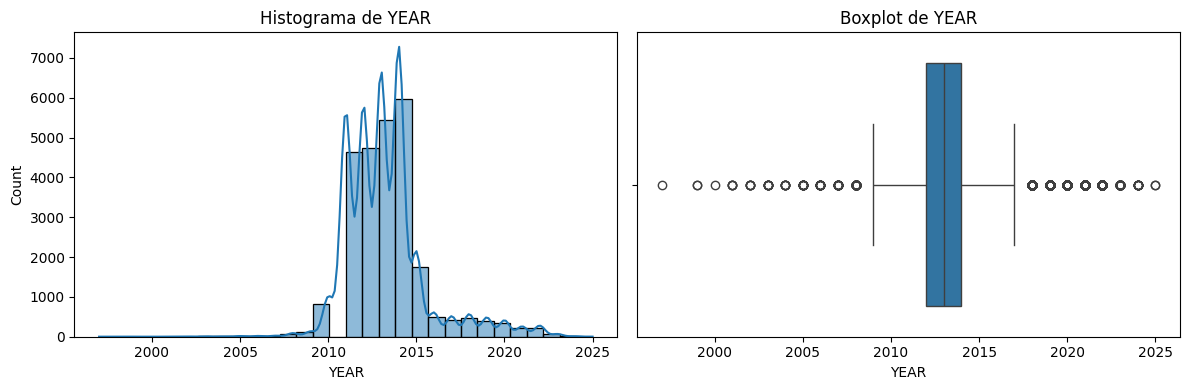

In [8]:
# EDA para variables numéricas
import matplotlib.pyplot as plt
import seaborn as sns

for col in FEATURE_SETS['numerical']:
    print(f"=== EDA para {col} ===")
    serie = df[col]
    # Estadísticos descriptivos
    print(serie.describe())
    missing = serie.isna().sum()
    print(f"Valores faltantes en {col}: {missing}\n")
    
    # Visualización
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(serie.dropna(), kde=True, bins=30)
    plt.title(f"Histograma de {col}")
    
    plt.subplot(1,2,2)
    sns.boxplot(x=serie.dropna())
    plt.title(f"Boxplot de {col}")
    
    plt.tight_layout()
    plt.show()


## 7.3 EDA para variables categóricas

Las variables categóricas contienen valores discretos como identificadores, marcas, modelos o fechas tratadas como categorías. Para cada variable categórica se exploran:

- El número de categorías distintas (`nunique`) y la cantidad de valores faltantes.
- Las categorías más frecuentes y su proporción respecto al total.
- Visualización de la distribución mediante gráficos de barras para detectar categorías dominantes y posible desequilibrio.

Se utiliza la lista `FEATURE_SETS['categorical']` para iterar por cada variable categórica presente en `df`.


=== EDA para ACTION_NUMBER ===
Número de categorías distintas: 105
Valores faltantes: 0
Top categorías:
ACTION_NUMBER
PE19004    7840
DP18003    7072
PE19003    6048
PE21003     940
DP22005     938
PE21011     459
PE20003     416
RQ19005     400
PE18003     315
EA19001     190
Name: count, dtype: int64


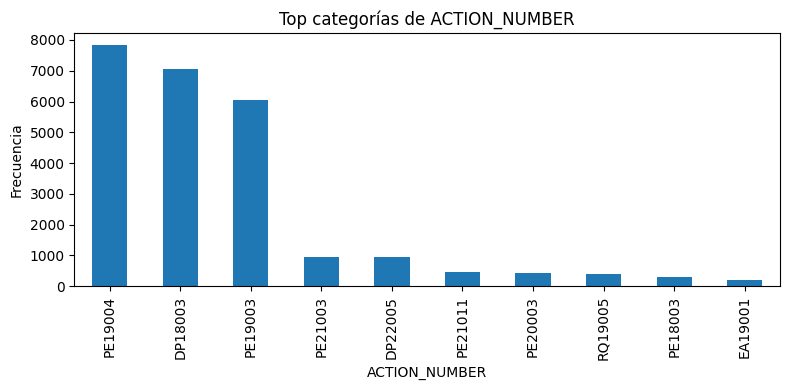


=== EDA para MAKE ===
Número de categorías distintas: 76
Valores faltantes: 0
Top categorías:
MAKE
KIA        12342
HYUNDAI     9222
DUCATI       940
FORD         536
PREVOST      456
AUTOCAR      288
HONDA        175
TESLA        161
TOYOTA       155
BMW          149
Name: count, dtype: int64


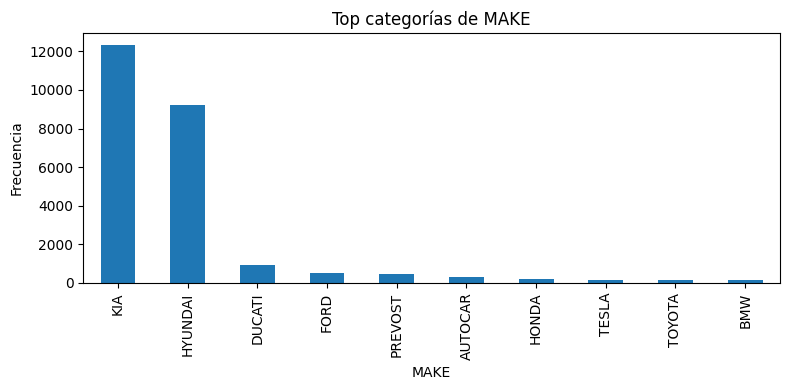


=== EDA para MODEL ===
Número de categorías distintas: 506
Valores faltantes: 0
Top categorías:
MODEL
SOUL              3605
SONATA            2644
SONATA HYBRID     2626
SANTA FE          2569
OPTIMA HYBRID     2422
OPTIMA            2420
SORENTO           2410
SANTA FE SPORT    1282
SOUL EV           1211
XPEDITOR           104
Name: count, dtype: int64


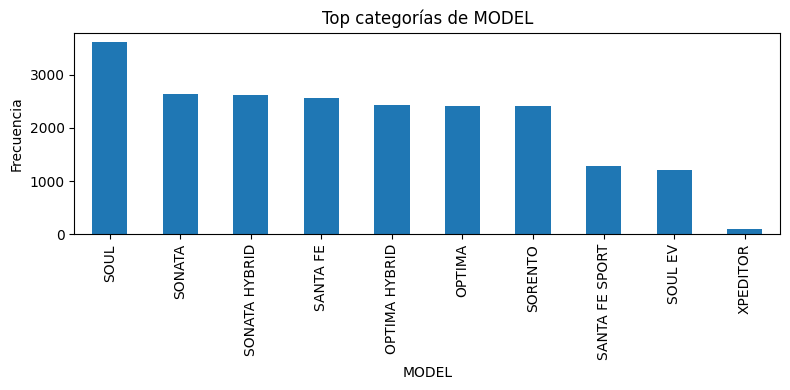


=== EDA para COMPONENT ===
Número de categorías distintas: 160
Valores faltantes: 0
Top categorías:
COMPONENT
ELECTRICAL SYSTEM:PROPULSION SYSTEM                                           952
ELECTRICAL SYSTEM:ALTERNATOR/GENERATOR/REGULATOR                              867
ENGINE                                                                        519
ELECTRICAL SYSTEM                                                             501
ENGINE AND ENGINE COOLING:EXHAUST SYSTEM                                      438
ENGINE AND ENGINE COOLING                                                     438
ENGINE AND ENGINE COOLING:EXHAUST SYSTEM:MANIFOLD/HEADER/MUFFLER/TAIL PIPE    438
ENGINE AND ENGINE COOLING:ENGINE                                              438
ELECTRICAL SYSTEM:12V/24V/48V BATTERY                                         430
ENGINE AND ENGINE COOLING:ENGINE:GASOLINE:TURBO/SUPERCHARGER                  428
Name: count, dtype: int64


/var/folders/_7/1zf2xp_55rq61_zjzydkzfk40000gn/T/ipykernel_59018/3214559916.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


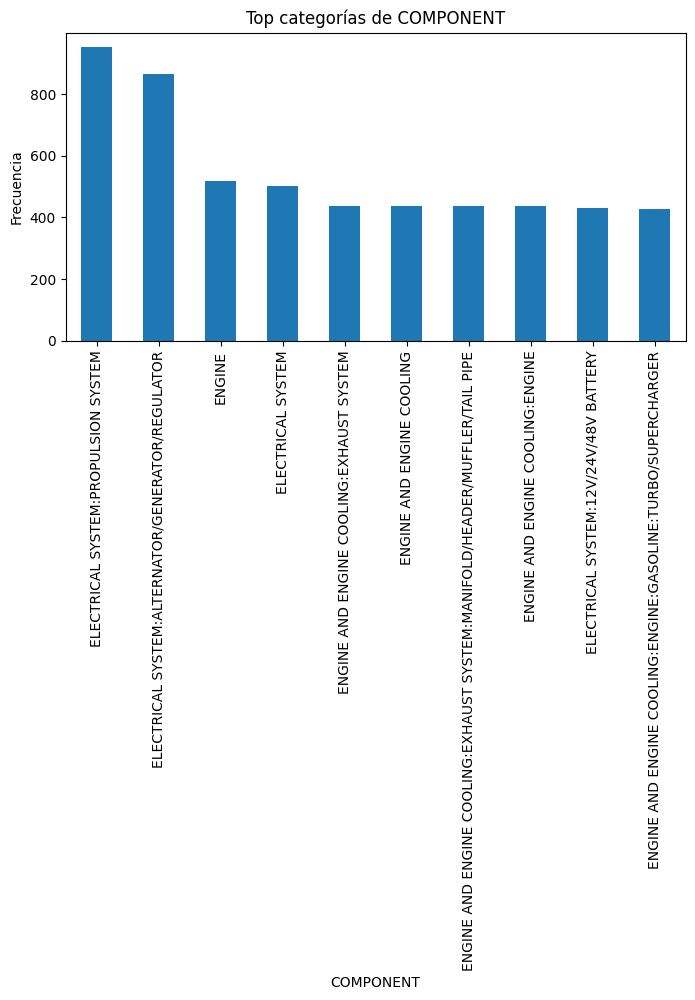


=== EDA para MFG_NAME ===
Número de categorías distintas: 59
Valores faltantes: 0
Top categorías:
MFG_NAME
Kia America, Inc.                    12355
Hyundai Motor America                 9234
Ducati North America                   940
Ford Motor Company                     663
Prevost Car (US) Inc.                  447
General Motors, LLC                    267
Toyota Motor Corporation               237
Honda (American Honda Motor Co.)       219
Volkswagen Group of America, Inc.      215
Autocar, LLC                           168
Name: count, dtype: int64


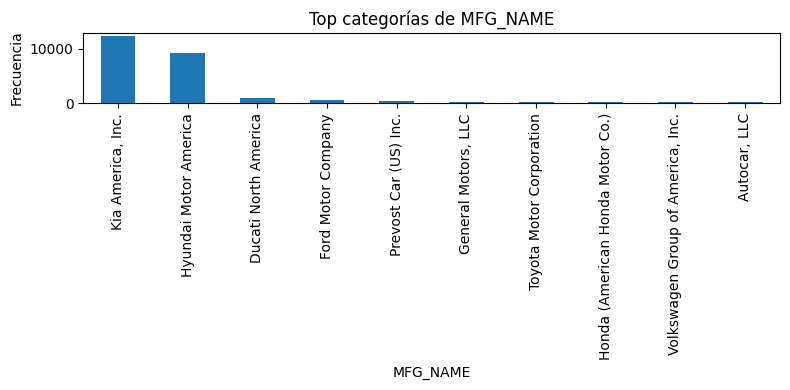


=== EDA para ODATE ===
Número de categorías distintas: 89
Valores faltantes: 0
Top categorías:
ODATE
2019-03-29    13888
2018-08-21     7142
2023-01-27      956
2021-02-18      940
2021-05-13      459
2020-04-01      431
2019-12-19      400
2018-03-16      315
2019-04-19      190
2017-09-18      160
Name: count, dtype: int64


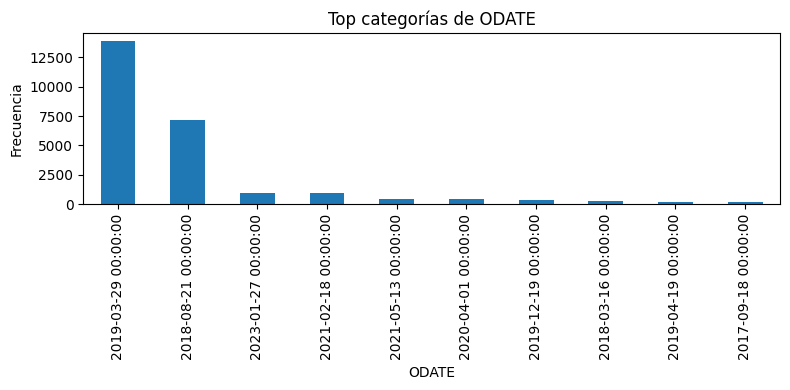


=== EDA para CDATE ===
Número de categorías distintas: 84
Valores faltantes: 56
Top categorías:
CDATE
2021-12-22    13924
2019-05-10     7072
2021-07-09      940
2023-08-07      938
2022-10-03      460
2022-02-07      424
2024-01-10      416
2019-08-30      315
2024-09-19      190
2024-07-01      138
Name: count, dtype: int64


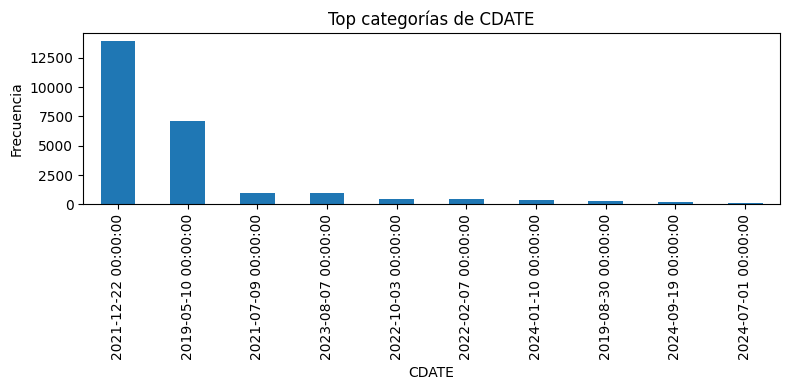


=== EDA para CAMP_NO ===
Número de categorías distintas: 146
Valores faltantes: 0
Top categorías:
CAMP_NO
19V204000    1768
18V934000    1768
18V907000    1768
19V120000    1768
20V750000     980
20V088000     980
20V100000     980
20V518000     980
20V519000     980
20V101000     980
Name: count, dtype: int64


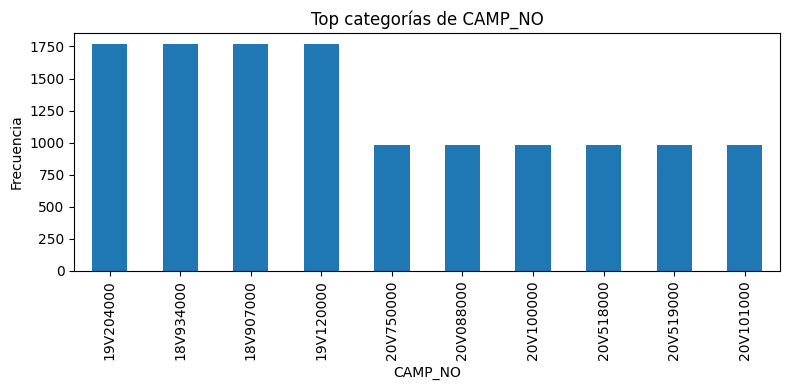


=== EDA para Inv_state ===
Número de categorías distintas: 2
Valores faltantes: 0
Top categorías:
Inv_state
closed    26225
open         56
Name: count, dtype: int64


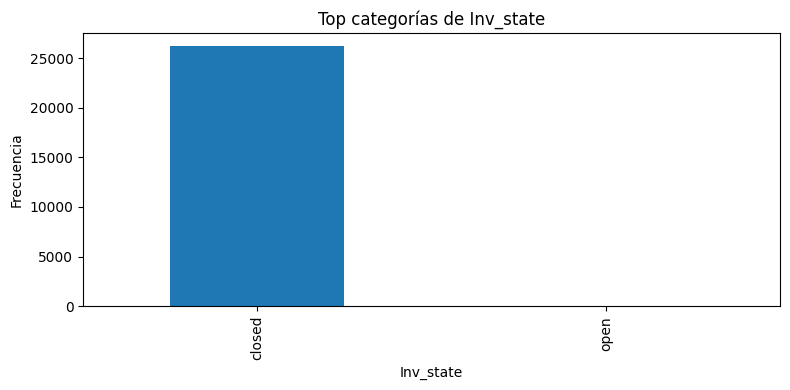

In [9]:
# EDA para variables categóricas
import matplotlib.pyplot as plt
import seaborn as sns

for col in FEATURE_SETS['categorical']:
    print(f"=== EDA para {col} ===")
    serie = df[col].astype('category')
    n_unique = serie.nunique(dropna=True)
    n_missing = serie.isna().sum()
    print(f"Número de categorías distintas: {n_unique}")
    print(f"Valores faltantes: {n_missing}")
    # Mostrar las 10 categorías más frecuentes (incluyendo NaN)
    top_categories = serie.value_counts(dropna=False).head(10)
    print("Top categorías:")
    print(top_categories)
    # Graficar distribución de las top categorías
    plt.figure(figsize=(8, 4))
    top_categories.plot(kind='bar')
    plt.title(f"Top categorías de {col}")
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()
    print("")


## 7.4 EDA para variables de texto

Las variables de texto contienen descripciones largas (como asunto y resumen). En el análisis exploratorio de estas columnas se consideran:

- Longitud de cada texto en caracteres y en número de palabras para identificar casos muy cortos o extremadamente largos.
- Estadísticos descriptivos de la longitud (mínimo, máximo, media, mediana y percentiles).
- Distribución de la longitud mediante histogramas.
- Palabras más frecuentes después de una limpieza básica (convertir a minúsculas, eliminar signos de puntuación y separar por espacios). Esto permite identificar temas o términos recurrentes en los reportes.

Se utiliza la lista `FEATURE_SETS['text']` para iterar sobre las columnas de texto (`SUBJECT` y `SUMMARY`).


=== EDA para SUBJECT ===
Estadísticos de longitud de caracteres:
count    26281.000000
mean        24.086032
std          6.327516
min         12.000000
25%         23.000000
50%         23.000000
75%         23.000000
max         98.000000
Name: SUBJECT, dtype: float64
Estadísticos de longitud de palabras:
count    26281.000000
mean         3.212054
std          1.129836
min          2.000000
25%          3.000000
50%          3.000000
75%          3.000000
max         16.000000
Name: SUBJECT, dtype: float64


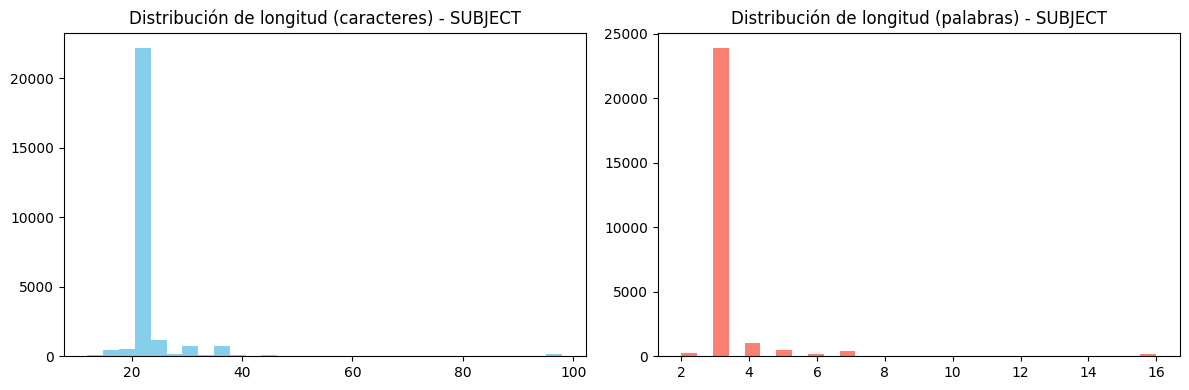

Palabras más frecuentes (top 20) después de quitar stopwords:
vehicle: 21410
crash: 21279
fires: 21044
non: 20966
failure: 1068
extended: 950
distance: 949
stopping: 940
pedestrian: 938
alert: 938
sounds: 938
latch: 486
alternator: 459
bearing: 459
failures: 436
door: 435
away: 420
roll: 416
fuel: 404
air: 322

=== EDA para SUMMARY ===
Estadísticos de longitud de caracteres:
count    26281.000000
mean      1932.987710
std        638.554285
min         36.000000
25%       1518.000000
50%       1590.000000
75%       2226.000000
max       5873.000000
Name: SUMMARY, dtype: float64
Estadísticos de longitud de palabras:
count    26281.000000
mean       289.434344
std        100.208689
min          5.000000
25%        225.000000
50%        231.000000
75%        336.000000
max        944.000000
Name: SUMMARY, dtype: float64


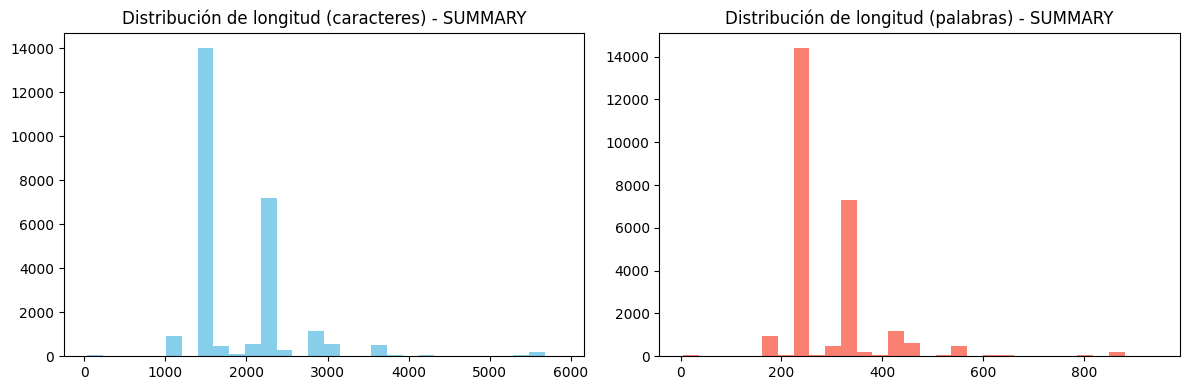

Palabras más frecuentes (top 20) después de quitar stopwords:
vehicles: 165433
odi: 125778
kia: 113695
engine: 86835
related: 83571
hyundai: 76730
nhtsa: 75627
fires: 70713
vehicle: 69778
recall: 68035
safety: 64983
information: 60927
available: 58050
petition: 56102
equipped: 52414
failures: 52096
non: 50714
potential: 50463
recalls: 45950
investigation: 43722



In [10]:
# EDA para variables de texto con tokenización y eliminación de stopwords
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Conjunto de stopwords en español (lista reducida de palabras comunes)
stopwords_es = set([
    'a', 'ante', 'bajo', 'con', 'contra', 'de', 'del', 'desde', 'en', 'entre',
    'hacia', 'hasta', 'para', 'por', 'sin', 'sobre', 'tras', 'el', 'la', 'los', 'las',
    'un', 'una', 'unos', 'unas', 'que', 'y', 'o', 'como', 'mas', 'más', 'menos', 'muy',
    'pero', 'porque', 'no', 'ni', 'si', 'se', 'ya', 'yo', 'tú', 'tu', 'él', 'ella',
    'ellos', 'ellas', 'nos', 'nosotros', 'usted', 'ustedes', 'mi', 'mis', 'su', 'sus',
    'me', 'te', 'lo', 'al'
])

stopwords_en = set(ENGLISH_STOP_WORDS)
stopwords_total = stopwords_es.union(stopwords_en)

# Función para tokenizar: convierte texto a minúsculas, elimina signos y filtra stopwords
def tokenizar(texto):
    if pd.isna(texto):
        return []
    texto = str(texto).lower()
    # Sustituir cualquier caracter que no sea letra o espacio por espacio
    texto = re.sub(r"[^a-záéíóúñü\s]", " ", texto)
    tokens = texto.split()
    # Filtrar stopwords y tokens muy cortos
    tokens = [tok for tok in tokens if tok not in stopwords_total and len(tok) > 2]
    return tokens

for col in FEATURE_SETS['text']:
    print(f"=== EDA para {col} ===")
    textos = df[col].dropna().astype(str)
    # Estadísticas de longitud
    longitudes = textos.apply(len)
    palabras_por_texto = textos.apply(lambda x: len(x.split()))
    print("Estadísticos de longitud de caracteres:")
    print(longitudes.describe())
    print("Estadísticos de longitud de palabras:")
    print(palabras_por_texto.describe())
    # Histogramas de longitud
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(longitudes, bins=30, color='skyblue')
    plt.title(f"Distribución de longitud (caracteres) - {col}")
    plt.subplot(1, 2, 2)
    plt.hist(palabras_por_texto, bins=30, color='salmon')
    plt.title(f"Distribución de longitud (palabras) - {col}")
    plt.tight_layout()
    plt.show()
    # Tokenización y stopwords
    tokens = []
    for txt in textos:
        tokens.extend(tokenizar(txt))
    # Conteo de palabras
    contador = Counter(tokens)
    top_words = contador.most_common(20)
    print("Palabras más frecuentes (top 20) después de quitar stopwords:")
    for palabra, freq in top_words:
        print(f"{palabra}: {freq}")
    print("")


## 7.6 Embeddings de texto con e5‑multilingual‑large

Como alternativa a los vectores TF‑IDF, es posible utilizar un modelo de lenguaje avanzado para generar **embeddings semánticos**. El modelo [**e5‑multilingual‑large**](https://huggingface.co/intfloat/multilingual-e5-large) produce representaciones vectoriales de alta calidad para textos en múltiples idiomas. Para cada fila se concatenan las columnas `SUBJECT` y `SUMMARY`, se preprocesa el texto (minúsculas, eliminación de signos y stopwords) y se obtienen los vectores mediante la biblioteca `sentence-transformers`. El modelo devuelve un vector de 1 024 dimensiones que captura el significado semántico del texto; estos vectores pueden usarse para tareas de clustering, búsqueda semántica o construcción de grafos de conocimiento.

**Nota**: La ejecución de este apartado requiere tener instalada la librería `sentence-transformers` y descargar previamente el modelo `intfloat/multilingual-e5-large`. Si el entorno no cuenta con acceso a internet, estos pasos deberán realizarse de antemano. Además, debido al tamaño del modelo, se recomienda procesar los textos en lotes para evitar problemas de memoria.

In [11]:
# Embeddings de texto con e5-multilingual-large (acelerado en Apple Silicon M3 vía MPS)
import os
import re
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    raise ImportError("La librería 'sentence-transformers' no está instalada. Instálala para usar e5-multilingual-large.")

# ---- Detección de GPU (MPS) en Mac ----
use_mps = False
device = "cpu"
try:
    import torch
    use_mps = torch.backends.mps.is_available()
    device = "mps" if use_mps else "cpu"
    if use_mps:
        # Mejor precisión en matmul; mantiene fp32 (seguro en MPS)
        try:
            torch.set_float32_matmul_precision("high")
        except Exception:
            pass
except Exception:
    device = "cpu"

print(f"Dispositivo seleccionado para embeddings: {device.upper()}")

# Definir stopwords en español e inglés (puede ampliarse)
stopwords_es = set([
    'a', 'ante', 'bajo', 'con', 'contra', 'de', 'del', 'desde', 'sin', 'entre',
    'hacia', 'hasta', 'para', 'por', 'sin', 'sobre', 'tras', 'la', 'los', 'las',
    'un', 'una', 'unos', 'unas', 'que', 'y', 'o', 'pero', 'porque', 'no', 'ni',
    'si', 'se', 'ya', 'yo', 'tu', 'él', 'ella', 'ellos', 'ellas', 'nos', 'nosotros',
    'ustedes', 'vos', 'tus', 'sus', 'mi', 'mis', 'su', 'sus', 'lo', 'la'
])
stopwords_en = set(ENGLISH_STOP_WORDS)
stopwords_total = stopwords_es.union(stopwords_en)

def preprocess(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = re.sub(r'[^a-záéíóúñü0-9 ]', ' ', text)
    tokens = text.split()
    tokens = [tok for tok in tokens if tok not in stopwords_total and len(tok) > 2]
    return ' '.join(tokens)

# Ruta para guardar/recuperar embeddings
embeddings_file = 'embeddings_e5_df.pkl'

# Si existe el archivo de embeddings, cargarlo para evitar recálculo
if os.path.exists(embeddings_file):
    embeddings_e5_df = pd.read_pickle(embeddings_file)
    print('Embeddings e5 cargados desde archivo', embeddings_file)
else:
    # Cargar modelo e5-multilingual-large en el dispositivo detectado (CPU/MPS)
    model = SentenceTransformer('intfloat/multilingual-e5-large', device=device)
    model.eval()  # redundante, pero explícito

    # Combinar columnas SUBJECT y SUMMARY
    if 'SUBJECT' not in df.columns or 'SUMMARY' not in df.columns:
        raise ValueError("Se requieren las columnas 'SUBJECT' y 'SUMMARY' en el DataFrame 'df'.")
    combined_texts = df['SUBJECT'].astype(str).fillna('') + ' ' + df['SUMMARY'].astype(str).fillna('')
    processed_texts = combined_texts.apply(preprocess).tolist()

    # Tamaño de batch: mayor si hay MPS
    batch_size = 64 if use_mps else 32

    # Generar embeddings (normalize_embeddings=True conserva tu lógica original)
    # Nota: 'device' aquí asegura ejecución en MPS si está disponible.
    embeddings_e5 = model.encode(
        processed_texts,
        batch_size=batch_size,
        device=device,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True
    )

    # Construir DataFrame de embeddings
    import numpy as np
    embeddings_e5 = np.nan_to_num(embeddings_e5, nan=0.0, posinf=0.0, neginf=0.0).astype('float32')
    e5_dim = embeddings_e5.shape[1]
    e5_cols = [f'e5_{i}' for i in range(e5_dim)]
    embeddings_e5_df = pd.DataFrame(embeddings_e5, columns=e5_cols)
    print('Shape de embeddings e5:', embeddings_e5_df.shape)

    # Guardar embeddings en archivo (cache)
    embeddings_e5_df.to_pickle(embeddings_file)
    print('Embeddings e5 guardados en', embeddings_file)

# Mostrar los primeros registros de los embeddings
embeddings_e5_df.head()

/Users/erickbtc/Downloads/DATA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dispositivo seleccionado para embeddings: MPS
Embeddings e5 cargados desde archivo embeddings_e5_df.pkl


,e5_0,e5_1,e5_2,e5_3,e5_4,e5_5,e5_6,e5_7,e5_8,e5_9,...,e5_1014,e5_1015,e5_1016,e5_1017,e5_1018,e5_1019,e5_1020,e5_1021,e5_1022,e5_1023
0,0.003142,-0.026851,0.002636,-0.014511,0.007309,-0.029597,-0.031933,0.096175,0.063605,-0.013089,...,-0.021081,-0.025598,-0.013046,-0.031772,-0.007036,0.001893,-0.007559,0.009434,-0.046139,0.005702
1,0.003142,-0.026851,0.002636,-0.014511,0.007309,-0.029597,-0.031933,0.096175,0.063605,-0.013089,...,-0.021081,-0.025598,-0.013046,-0.031772,-0.007036,0.001893,-0.007559,0.009434,-0.046139,0.005702
2,0.003142,-0.026851,0.002636,-0.014511,0.007309,-0.029597,-0.031933,0.096175,0.063605,-0.013089,...,-0.021081,-0.025598,-0.013046,-0.031772,-0.007036,0.001893,-0.007559,0.009434,-0.046139,0.005702
3,0.003142,-0.026851,0.002636,-0.014511,0.007309,-0.029597,-0.031933,0.096175,0.063605,-0.013089,...,-0.021081,-0.025598,-0.013046,-0.031772,-0.007036,0.001893,-0.007559,0.009434,-0.046139,0.005702
4,0.003142,-0.026851,0.002636,-0.014511,0.007309,-0.029597,-0.031933,0.096175,0.063605,-0.013089,...,-0.021081,-0.025598,-0.013046,-0.031772,-0.007036,0.001893,-0.007559,0.009434,-0.046139,0.005702


In [12]:
# === Gestión robusta de cache de embeddings e5 (PKL) ===
# Si existe un archivo PKL en /mnt/data, cargarlo; si la longitud coincide con df, usarlo.
# Caso contrario, usar embeddings_e5_df ya en memoria y guardar a cache.
import os
import pandas as pd

pkl_path = 'embeddings_e5_df.pkl'

if 'embeddings_e5_df' in globals():
    cache_df = None
    if os.path.exists(pkl_path):
        try:
            cache_df = pd.read_pickle(pkl_path)
            print(f'📁 Se cargó embeddings_e5_df desde cache: {pkl_path}')
        except Exception as e:
            print(f'⚠️ Error al cargar {pkl_path}: {e}')

    if cache_df is not None and len(cache_df) == len(df):
        # Alinear índice con df
        embeddings_e5_df = cache_df.copy()
        embeddings_e5_df.index = df.index
        print('✅ Cache de embeddings coincide en número de filas; se usó sin recalcular.')
    else:
        # Guardar embeddings actuales
        embeddings_e5_df = embeddings_e5_df.copy()
        embeddings_e5_df.index = df.index
        try:
            embeddings_e5_df.to_pickle(pkl_path)
            print(f'📝 Cache de embeddings creado/actualizado en: {pkl_path}')
        except Exception as e:
            print(f'⚠️ Error al guardar {pkl_path}: {e}')
else:
    raise RuntimeError('embeddings_e5_df no existe en el espacio de trabajo.')

📁 Se cargó embeddings_e5_df desde cache: embeddings_e5_df.pkl
✅ Cache de embeddings coincide en número de filas; se usó sin recalcular.


## 8. Creación del grafo de conocimiento basado en embeddings

Esta sección replica la lógica utilizada en el cuaderno de quejas (Compl) para construir un grafo de conocimiento.  Se generan nodos para cada investigación y para cada valor único de variables categóricas importantes, se calculan embeddings de estas categorías con el mismo modelo **e5‑multilingual‑large** y se crean aristas basadas en similitud coseno.  Los umbrales de similitud se calibran mediante percentiles de las similitudes de pares reales.

In [13]:

# --- Preparativos ---
# Convertir las embeddings de texto en matriz NumPy (normalizadas).
import numpy as np
from tqdm import tqdm

# Aseguramos que embeddings_e5_df existe; de lo contrario, se lanza un error.
if 'embeddings_e5_df' not in globals():
    raise RuntimeError('No se encontró embeddings_e5_df; ejecute previamente la celda de generación de embeddings.')

# Matriz de embeddings de investigaciones (filas en el mismo orden que df).
embeddings_text = embeddings_e5_df.values.astype('float32')

# Función para codificar listas de cadenas utilizando el mismo modelo e5-multilingual-large.
def encode_list(strings, model, batch_size=32):
    # Codifica una lista de textos utilizando el modelo SentenceTransformer.
    # Devuelve una matriz (n, d) de embeddings normalizados en float32.
    if not strings:
        return np.empty((0, embeddings_text.shape[1]), dtype='float32')
    vecs = model.encode(
        strings,
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True
    )
    return vecs.astype('float32')

# Asegurar que el modelo e5 multilingüe está cargado; si no, cargarlo.
try:
    model
except NameError:
    from sentence_transformers import SentenceTransformer
    device = 'cpu'
    try:
        import torch
        if torch.backends.mps.is_available():
            device = 'mps'
    except Exception:
        device = 'cpu'
    model = SentenceTransformer('intfloat/multilingual-e5-large', device=device)
    model.eval()

# 8.1 Preparación de listas de entidades
# Construcción de llave de vehículo y listas de entidades.
df['VEHICLE_KEY'] = (
    df['MAKE'].fillna('').astype(str).str.strip() + ' ' +
    df['MODEL'].fillna('').astype(str).str.strip() + ' (' +
    df['YEAR'].fillna('').astype(str) + ')'
).str.replace(r"\s+", " ", regex=True).str.strip()

# Listas de valores únicos para cada categoría relevante
unique_components   = sorted(df['COMPONENT'].dropna().astype(str).str.strip().unique().tolist())
unique_makes        = sorted(df['MAKE'].dropna().astype(str).str.strip().unique().tolist())
unique_models       = sorted(df['MODEL'].dropna().astype(str).str.strip().unique().tolist())
unique_mfg_names    = sorted(df['MFG_NAME'].dropna().astype(str).str.strip().unique().tolist())
unique_camp_no      = sorted(df['CAMP_NO'].dropna().astype(str).str.strip().unique().tolist())
unique_vehicle_keys = sorted(df['VEHICLE_KEY'].dropna().astype(str).str.strip().unique().tolist())

print('Número de componentes únicos:', len(unique_components))
print('Número de marcas únicas:', len(unique_makes))
print('Número de modelos únicos:', len(unique_models))
print('Número de fabricantes únicos:', len(unique_mfg_names))
print('Número de campañas únicas:', len(unique_camp_no))
print('Número de claves de vehículo únicas:', len(unique_vehicle_keys))

# 8.2 Embedding de entidades
comp_emb    = encode_list(unique_components, model)
make_emb    = encode_list(unique_makes, model)
model_emb   = encode_list(unique_models, model)
mfg_emb     = encode_list(unique_mfg_names, model)
camp_emb    = encode_list(unique_camp_no, model)
veh_emb     = encode_list(unique_vehicle_keys, model)

# 8.3 Calibración de umbrales de similitud
import pandas as pd

# Mapeos para obtener el índice de cada entidad
comp_to_idx    = {c: i for i, c in enumerate(unique_components)}
make_to_idx    = {c: i for i, c in enumerate(unique_makes)}
model_to_idx   = {c: i for i, c in enumerate(unique_models)}
mfg_to_idx     = {c: i for i, c in enumerate(unique_mfg_names)}
camp_to_idx    = {c: i for i, c in enumerate(unique_camp_no)}
veh_to_idx     = {c: i for i, c in enumerate(unique_vehicle_keys)}

# Función para calcular percentil 25 de similitudes reales
def calibrate_threshold(df_col, mapping, emb_matrix):
    sims = []
    rng = np.random.RandomState(42)
    sample_idx = rng.choice(len(df), size=min(5000, len(df)), replace=False)
    for idx in sample_idx:
        val = df.iloc[idx][df_col]
        if pd.isna(val):
            continue
        key = str(val).strip()
        if key not in mapping:
            continue
        j = mapping[key]
        s = float(embeddings_text[idx : idx + 1] @ emb_matrix[j : j + 1].T)
        sims.append(s)
    if not sims:
        return 0.0
    sims = np.array(sims)
    thr = float(np.percentile(sims, 25))
    return thr

THR_COMP  = calibrate_threshold('COMPONENT', comp_to_idx, comp_emb)
THR_MAKE  = calibrate_threshold('MAKE', make_to_idx, make_emb)
THR_MODEL = calibrate_threshold('MODEL', model_to_idx, model_emb)
THR_MFG   = calibrate_threshold('MFG_NAME', mfg_to_idx, mfg_emb)
THR_CAMP  = calibrate_threshold('CAMP_NO', camp_to_idx, camp_emb)
THR_VEH   = calibrate_threshold('VEHICLE_KEY', veh_to_idx, veh_emb)

print('Umbral texto→COMPONENT:', THR_COMP)
print('Umbral texto→MAKE:', THR_MAKE)
print('Umbral texto→MODEL:', THR_MODEL)
print('Umbral texto→MFG_NAME:', THR_MFG)
print('Umbral texto→CAMP_NO:', THR_CAMP)
print('Umbral texto→VEHICLE_KEY:', THR_VEH)

# 8.4 Cálculo eficiente de similitudes (top‑k)
def batched_topk_sims(A, B, topk=3, batch=512):
    results = []
    for i in tqdm(range(0, A.shape[0], batch), desc='Buscando vecinos por similitud'):
        Ai = A[i : i + batch]
        S = Ai @ B.T
        k = min(topk, S.shape[1])
        top_idx = np.argpartition(-S, kth=k - 1, axis=1)[:, :k]
        rows = np.arange(S.shape[0])[:, None]
        vals = np.take_along_axis(S, top_idx, axis=1)
        order = np.argsort(-vals, axis=1)
        top_sorted = np.take_along_axis(top_idx, order, axis=1)
        vals_sorted = np.take_along_axis(vals, order, axis=1)
        for r in range(top_sorted.shape[0]):
            a_idx = i + r
            for c in range(top_sorted.shape[1]):
                b_idx = int(top_sorted[r, c])
                score = float(vals_sorted[r, c])
                results.append((a_idx, b_idx, score))
    return results

# Candidatos de similitud
txt_to_comp_candidates  = batched_topk_sims(embeddings_text, comp_emb,  topk=3, batch=512)
txt_to_make_candidates  = batched_topk_sims(embeddings_text, make_emb,  topk=1, batch=512)
txt_to_model_candidates = batched_topk_sims(embeddings_text, model_emb, topk=1, batch=512)
txt_to_mfg_candidates   = batched_topk_sims(embeddings_text, mfg_emb,   topk=1, batch=512)
txt_to_camp_candidates  = batched_topk_sims(embeddings_text, camp_emb,  topk=1, batch=512)
txt_to_veh_candidates   = batched_topk_sims(embeddings_text, veh_emb,   topk=1, batch=512)

# Filtrado por umbrales
edges_txt_comp  = [(a, unique_components[b], s)    for (a,b,s) in txt_to_comp_candidates  if s >= THR_COMP]
edges_txt_make  = [(a, unique_makes[b], s)        for (a,b,s) in txt_to_make_candidates  if s >= THR_MAKE]
edges_txt_model = [(a, unique_models[b], s)       for (a,b,s) in txt_to_model_candidates if s >= THR_MODEL]
edges_txt_mfg   = [(a, unique_mfg_names[b], s)    for (a,b,s) in txt_to_mfg_candidates   if s >= THR_MFG]
edges_txt_camp  = [(a, unique_camp_no[b], s)      for (a,b,s) in txt_to_camp_candidates  if s >= THR_CAMP]
edges_txt_veh   = [(a, unique_vehicle_keys[b], s) for (a,b,s) in txt_to_veh_candidates   if s >= THR_VEH]

print('Aristas texto→COMPONENT:', len(edges_txt_comp))
print('Aristas texto→MAKE:', len(edges_txt_make))
print('Aristas texto→MODEL:', len(edges_txt_model))
print('Aristas texto→MFG_NAME:', len(edges_txt_mfg))
print('Aristas texto→CAMP_NO:', len(edges_txt_camp))
print('Aristas texto→VEHICLE_KEY:', len(edges_txt_veh))

# 8.5 Construcción de tablas de nodos y aristas
nodes = []
for i, row in df.reset_index(drop=True).iterrows():
    nodes.append({
        'id': f"investigation_{i}",
        'type': 'investigation',
        'year': row.get('YEAR', np.nan),
        'state': row.get('Inv_state', np.nan)
    })
for c in unique_components:
    nodes.append({'id': f"component_{c}", 'type': 'component'})
for m in unique_makes:
    nodes.append({'id': f"make_{m}", 'type': 'make'})
for m in unique_models:
    nodes.append({'id': f"model_{m}", 'type': 'model'})
for f in unique_mfg_names:
    nodes.append({'id': f"mfg_{f}", 'type': 'mfg_name'})
for c in unique_camp_no:
    nodes.append({'id': f"camp_{c}", 'type': 'camp_no'})
for v in unique_vehicle_keys:
    nodes.append({'id': f"vehicle_{v}", 'type': 'vehicle'})

edges = []
for a_idx, comp_str, score in edges_txt_comp:
    edges.append({'source': f"investigation_{a_idx}", 'target': f"component_{comp_str}", 'relation': 'mentions_component_semantic', 'weight': round(score, 4)})
for a_idx, make_str, score in edges_txt_make:
    edges.append({'source': f"investigation_{a_idx}", 'target': f"make_{make_str}", 'relation': 'mentions_make_semantic', 'weight': round(score, 4)})
for a_idx, model_str, score in edges_txt_model:
    edges.append({'source': f"investigation_{a_idx}", 'target': f"model_{model_str}", 'relation': 'mentions_model_semantic', 'weight': round(score, 4)})
for a_idx, mfg_str, score in edges_txt_mfg:
    edges.append({'source': f"investigation_{a_idx}", 'target': f"mfg_{mfg_str}", 'relation': 'mentions_mfg_semantic', 'weight': round(score, 4)})
for a_idx, camp_str, score in edges_txt_camp:
    edges.append({'source': f"investigation_{a_idx}", 'target': f"camp_{camp_str}", 'relation': 'mentions_camp_semantic', 'weight': round(score, 4)})
for a_idx, veh_str, score in edges_txt_veh:
    edges.append({'source': f"investigation_{a_idx}", 'target': f"vehicle_{veh_str}", 'relation': 'mentions_vehicle_semantic', 'weight': round(score, 4)})

nodes_df = pd.DataFrame(nodes)
edges_df = pd.DataFrame(edges)

print('Número total de nodos:', len(nodes_df))
print('Número total de aristas:', len(edges_df))

# Mostrar una muestra de las tablas
nodes_df.head()
edges_df.head()


Número de componentes únicos: 160
Número de marcas únicas: 76
Número de modelos únicos: 506
Número de fabricantes únicos: 59
Número de campañas únicas: 146
Número de claves de vehículo únicas: 2075


Batches: 100%|██████████| 65/65 [00:04<00:00, 13.11it/s]
/var/folders/_7/1zf2xp_55rq61_zjzydkzfk40000gn/T/ipykernel_59018/3570476490.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = float(embeddings_text[idx : idx + 1] @ emb_matrix[j : j + 1].T)


Umbral texto→COMPONENT: 0.7653546333312988
Umbral texto→MAKE: 0.7868947982788086
Umbral texto→MODEL: 0.7395458817481995
Umbral texto→MFG_NAME: 0.7834814190864563
Umbral texto→CAMP_NO: 0.7569601535797119
Umbral texto→VEHICLE_KEY: 0.8036913275718689


Buscando vecinos por similitud: 100%|██████████| 52/52 [00:00<00:00, 262.77it/s]


Aristas texto→COMPONENT: 78843
Aristas texto→MAKE: 21585
Aristas texto→MODEL: 26281
Aristas texto→MFG_NAME: 23665
Aristas texto→CAMP_NO: 26281
Aristas texto→VEHICLE_KEY: 26110
Número total de nodos: 29303
Número total de aristas: 202765


,source,target,relation,weight
0,investigation_0,component_ENGINE AND ENGINE COOLING:ENGINE:OTH...,mentions_component_semantic,0.7963
1,investigation_0,component_VISIBILITY:WINDSHIELD WIPER/WASHER:M...,mentions_component_semantic,0.7946
2,investigation_0,component_AIR BAGS:FRONTAL:DRIVER SIDE:INFLATO...,mentions_component_semantic,0.7920
3,investigation_1,component_ENGINE AND ENGINE COOLING:ENGINE:OTH...,mentions_component_semantic,0.7963
4,investigation_1,component_VISIBILITY:WINDSHIELD WIPER/WASHER:M...,mentions_component_semantic,0.7946


In [14]:
# === Exportación CSV: Nodos por categoría + Aristas por tipo (Neo4j-ready) ===
import os, re, csv
import pandas as pd

# --- Validaciones mínimas ---
if 'nodes_df' not in globals():
    raise RuntimeError("No existe nodes_df. Ejecuta primero la celda que construye los nodos.")
if 'edges_df' not in globals():
    raise RuntimeError("No existe edges_df. Ejecuta primero la celda que construye las aristas.")

os.makedirs("export", exist_ok=True)

# --- Utilidades ---
def to_id(s: str) -> str:
    """ID seguro (coincide entre nodos y aristas)."""
    return re.sub(r'[^A-Za-z0-9_.:-]', '_', str(s))

def safe_name(s: str) -> str:
    """Nombre de archivo seguro."""
    return re.sub(r'[^A-Za-z0-9_.:-]', '_', str(s))

# Para derivar 'name' a partir del prefijo del id
prefix_map = {
    'investigation': 'investigation_',
    'component':     'component_',
    'make':          'make_',
    'model':         'model_',
    'mfg_name':      'mfg_',
    'camp_no':       'camp_',
    'vehicle':       'vehicle_',
}

def derive_name(row):
    t, i = row['type'], row['id']
    pref = prefix_map.get(t, '')
    if t == 'investigation':
        return str(i)  # puedes cambiarlo por un display más corto si quieres
    return str(i[len(pref):]) if pref and str(i).startswith(pref) else str(i)

# Columnas extra por categoría (si existen en nodes_df)
extra_cols_by_cat = {
    'investigation': ['year','state'],
    'component':     [],
    'make':          [],
    'model':         [],
    'mfg_name':      [],
    'camp_no':       [],
    'vehicle':       [],
}

# --- NODOS por categoría ---
_nodes = nodes_df.copy()
_nodes[':ID']    = _nodes['id'].map(to_id)
_nodes[':LABEL'] = _nodes['type'].astype(str)
if 'name' not in _nodes.columns:
    _nodes['name'] = _nodes.apply(derive_name, axis=1)

exportados_nodos = []
total_nodos = 0

for cat in sorted(_nodes[':LABEL'].unique()):
    sub = _nodes[_nodes[':LABEL'] == cat].copy()
    if sub.empty:
        continue
    cols = [':ID','name'] + [c for c in extra_cols_by_cat.get(cat, []) if c in sub.columns] + [':LABEL']
    sub = sub[cols].drop_duplicates(subset=':ID', keep='first')
    path = f"export/nodes_{safe_name(cat)}.csv"
    sub.to_csv(path, index=False, encoding='utf-8', quoting=csv.QUOTE_MINIMAL)
    exportados_nodos.append((cat, len(sub), path))
    total_nodos += len(sub)

# Conjunto de IDs válidos para validar aristas
node_ids = set(_nodes[':ID'].unique())

# --- ARISTAS por tipo ---
_edges = edges_df.copy()
_edges[':START_ID'] = _edges['source'].map(to_id)
_edges[':END_ID']   = _edges['target'].map(to_id)
_edges[':TYPE']     = _edges['relation'].astype(str)

# Añadir peso si está presente
cols_edges = [':START_ID', ':END_ID', ':TYPE']
if 'weight' in _edges.columns:
    _edges['weight:float'] = _edges['weight'].astype(float)
    cols_edges.append('weight:float')

# Limpieza: sin self-loops, sin duplicados
_edges = _edges[_edges[':START_ID'] != _edges[':END_ID']]
_edges = _edges[cols_edges].drop_duplicates()

# Validación: conservar solo aristas cuyos nodos existan
before = len(_edges)
_edges = _edges[_edges[':START_ID'].isin(node_ids) & _edges[':END_ID'].isin(node_ids)]
dropped_missing = before - len(_edges)

exportadas_edges = []
total_edges = 0
for rel, g in _edges.groupby(':TYPE', sort=True):
    path = f"export/edges_{safe_name(rel)}.csv"
    g.to_csv(path, index=False, encoding='utf-8', quoting=csv.QUOTE_MINIMAL)
    exportadas_edges.append((rel, len(g), path))
    total_edges += len(g)

# --- Resumen ---
print("✅ Nodos exportados por categoría:")
for cat, n, p in exportados_nodos:
    print(f"  • {cat}: {n:,} → {p}")
print(f"Total nodos exportados: {total_nodos:,}")

print("\n✅ Aristas exportadas por tipo de relación:")
for rel, n, p in exportadas_edges:
    print(f"  • {rel}: {n:,} → {p}")
print(f"Total aristas exportadas: {total_edges:,}")

if dropped_missing > 0:
    print(f"\n⚠️ Aristas descartadas por nodos inexistentes: {dropped_missing:,}")
else:
    print("\n🧩 Todas las aristas referencian nodos existentes.")

print("\n📂 Carpeta de salida: ./export")

✅ Nodos exportados por categoría:
  • camp_no: 146 → export/nodes_camp_no.csv
  • component: 160 → export/nodes_component.csv
  • investigation: 26,281 → export/nodes_investigation.csv
  • make: 76 → export/nodes_make.csv
  • mfg_name: 59 → export/nodes_mfg_name.csv
  • model: 506 → export/nodes_model.csv
  • vehicle: 2,075 → export/nodes_vehicle.csv
Total nodos exportados: 29,303

✅ Aristas exportadas por tipo de relación:
  • mentions_camp_semantic: 26,281 → export/edges_mentions_camp_semantic.csv
  • mentions_component_semantic: 78,843 → export/edges_mentions_component_semantic.csv
  • mentions_make_semantic: 21,585 → export/edges_mentions_make_semantic.csv
  • mentions_mfg_semantic: 23,665 → export/edges_mentions_mfg_semantic.csv
  • mentions_model_semantic: 26,281 → export/edges_mentions_model_semantic.csv
  • mentions_vehicle_semantic: 26,110 → export/edges_mentions_vehicle_semantic.csv
Total aristas exportadas: 202,765

🧩 Todas las aristas referencian nodos existentes.

📂 Carpet

In [15]:
# 9. Construcción de nodos y aristas adicionales a partir de variables no embeddings
#
# Este bloque genera nodos para las variables `YEAR` e `Inv_state` y construye
# aristas explícitas que conectan cada investigación con los valores exactos de sus
# variables categóricas (COMPONENT, MAKE, MODEL, MFG_NAME, CAMP_NO y VEHICLE_KEY).
# También define relaciones jerárquicas entre las entidades (modelo→marca, componente→modelo,
# componente→fabricante de piezas, marca→fabricante de piezas, modelo→fabricante de piezas,
# campaña→componentes/modelos/marcas y vehículo→marca/modelo/año).

import pandas as pd
import numpy as np

# Comprobar que el DataFrame de investigaciones está disponible
if 'df' not in globals():
    raise RuntimeError('No existe el DataFrame df. Ejecute las celdas previas de limpieza antes de esta celda.')

# 9.1 Nodos para YEAR e Inv_state
unique_years = sorted(df['YEAR'].dropna().astype(int).unique().tolist())
unique_states = sorted(df['Inv_state'].dropna().astype(str).unique().tolist())

additional_nodes = []
for y in unique_years:
    additional_nodes.append({'id': f'year_{int(y)}', 'type': 'year', 'value': int(y)})
for s in unique_states:
    additional_nodes.append({'id': f'state_{s}', 'type': 'state', 'value': s})

additional_nodes_df = pd.DataFrame(additional_nodes)

# 9.2 Aristas explícitas investigación → variables
additional_edges = []

# Iterar sobre cada investigación
for i, row in df.reset_index(drop=True).iterrows():
    inv_id = f'investigation_{i}'
    # a) aristas a year y state
    y = row.get('YEAR')
    if pd.notna(y):
        try:
            y_int = int(y)
            additional_edges.append({'source': inv_id, 'target': f'year_{y_int}', 'relation': 'has_year'})
        except Exception:
            pass
    st = row.get('Inv_state')
    if pd.notna(st):
        additional_edges.append({'source': inv_id, 'target': f'state_{st}', 'relation': 'has_state'})
    # b) aristas explícitas a cada campo categórico
    field_defs = [
        ('COMPONENT', 'component_', 'mentions_component_explicit'),
        ('MAKE',      'make_',      'mentions_make_explicit'),
        ('MODEL',     'model_',     'mentions_model_explicit'),
        ('MFG_NAME',  'mfg_',       'mentions_mfg_explicit'),
        ('CAMP_NO',   'camp_',      'mentions_camp_explicit'),
        ('VEHICLE_KEY','vehicle_',  'mentions_vehicle_explicit'),
    ]
    for col, prefix, rel in field_defs:
        val = row.get(col)
        if pd.notna(val):
            val_str = str(val).strip()
            additional_edges.append({'source': inv_id, 'target': f'{prefix}{val_str}', 'relation': rel})

# 9.3 Relaciones jerárquicas entre entidades (deduplicadas)
# Modelo → Marca
if {'MODEL','MAKE'}.issubset(df.columns):
    pairs = df[['MODEL','MAKE']].dropna().drop_duplicates().values
    for model_val, make_val in pairs:
        model_str = str(model_val).strip()
        make_str  = str(make_val).strip()
        additional_edges.append({
            'source': f'model_{model_str}',
            'target': f'make_{make_str}',
            'relation': 'model_of_make'
        })
# Componente → Modelo
if {'COMPONENT','MODEL'}.issubset(df.columns):
    pairs = df[['COMPONENT','MODEL']].dropna().drop_duplicates().values
    for comp_val, model_val in pairs:
        comp_str  = str(comp_val).strip()
        model_str = str(model_val).strip()
        additional_edges.append({
            'source': f'component_{comp_str}',
            'target': f'model_{model_str}',
            'relation': 'component_of_model'
        })
# Componente → Fabricante de piezas (MFG_NAME)
if {'COMPONENT','MFG_NAME'}.issubset(df.columns):
    pairs = df[['COMPONENT','MFG_NAME']].dropna().drop_duplicates().values
    for comp_val, mfg_val in pairs:
        comp_str = str(comp_val).strip()
        mfg_str  = str(mfg_val).strip()
        additional_edges.append({
            'source': f'component_{comp_str}',
            'target': f'mfg_{mfg_str}',
            'relation': 'component_manufactured_by'
        })
# Marca → Fabricante de piezas
if {'MAKE','MFG_NAME'}.issubset(df.columns):
    pairs = df[['MAKE','MFG_NAME']].dropna().drop_duplicates().values
    for make_val, mfg_val in pairs:
        make_str = str(make_val).strip()
        mfg_str  = str(mfg_val).strip()
        additional_edges.append({
            'source': f'make_{make_str}',
            'target': f'mfg_{mfg_str}',
            'relation': 'make_manufactured_by'
        })
# Modelo → Fabricante de piezas
if {'MODEL','MFG_NAME'}.issubset(df.columns):
    pairs = df[['MODEL','MFG_NAME']].dropna().drop_duplicates().values
    for model_val, mfg_val in pairs:
        model_str = str(model_val).strip()
        mfg_str   = str(mfg_val).strip()
        additional_edges.append({
            'source': f'model_{model_str}',
            'target': f'mfg_{mfg_str}',
            'relation': 'model_manufactured_by'
        })
# Campaña → Componentes/Modelos/Marcas
if {'CAMP_NO','COMPONENT'}.issubset(df.columns):
    pairs = df[['CAMP_NO','COMPONENT']].dropna().drop_duplicates().values
    for camp_val, comp_val in pairs:
        camp_str = str(camp_val).strip()
        comp_str = str(comp_val).strip()
        additional_edges.append({
            'source': f'camp_{camp_str}',
            'target': f'component_{comp_str}',
            'relation': 'campaign_targets_component'
        })
if {'CAMP_NO','MODEL'}.issubset(df.columns):
    pairs = df[['CAMP_NO','MODEL']].dropna().drop_duplicates().values
    for camp_val, model_val in pairs:
        camp_str  = str(camp_val).strip()
        model_str = str(model_val).strip()
        additional_edges.append({
            'source': f'camp_{camp_str}',
            'target': f'model_{model_str}',
            'relation': 'campaign_targets_model'
        })
if {'CAMP_NO','MAKE'}.issubset(df.columns):
    pairs = df[['CAMP_NO','MAKE']].dropna().drop_duplicates().values
    for camp_val, make_val in pairs:
        camp_str = str(camp_val).strip()
        make_str = str(make_val).strip()
        additional_edges.append({
            'source': f'camp_{camp_str}',
            'target': f'make_{make_str}',
            'relation': 'campaign_targets_make'
        })
# Vehículo → Marca/Modelo/Año (basado en VEHICLE_KEY)
if {'VEHICLE_KEY','MAKE','MODEL','YEAR'}.issubset(df.columns):
    combos = df[['VEHICLE_KEY','MAKE','MODEL','YEAR']].dropna().drop_duplicates()
    for _, row_v in combos.iterrows():
        v_str    = str(row_v['VEHICLE_KEY']).strip()
        make_str = str(row_v['MAKE']).strip()
        model_str= str(row_v['MODEL']).strip()
        try:
            year_int = int(row_v['YEAR'])
        except Exception:
            continue
        additional_edges.append({
            'source': f'vehicle_{v_str}',
            'target': f'make_{make_str}',
            'relation': 'vehicle_of_make'
        })
        additional_edges.append({
            'source': f'vehicle_{v_str}',
            'target': f'model_{model_str}',
            'relation': 'vehicle_of_model'
        })
        additional_edges.append({
            'source': f'vehicle_{v_str}',
            'target': f'year_{year_int}',
            'relation': 'vehicle_of_year'
        })

# Convertir a DataFrame
additional_edges_df = pd.DataFrame(additional_edges)

print('Nodos adicionales creados:', len(additional_nodes_df))
print('Aristas adicionales creadas:', len(additional_edges_df))

# Mostrar ejemplos de las tablas resultantes
try:
    from IPython.display import display
    display(additional_nodes_df.head())
    display(additional_edges_df.head())
except Exception:
    print(additional_nodes_df.head())
    print(additional_edges_df.head())

# 9.4 Integración opcional con el grafo existente
# Si nodes_df y edges_df ya existen en el entorno, se pueden concatenar los resultados
if 'nodes_df' in globals():
    nodes_df = pd.concat([nodes_df, additional_nodes_df], ignore_index=True)
    nodes_df = nodes_df.drop_duplicates(subset='id').reset_index(drop=True)
if 'edges_df' in globals():
    edges_df = pd.concat([edges_df, additional_edges_df], ignore_index=True)


Nodos adicionales creados: 30
Aristas adicionales creadas: 221910


,id,type,value
0,year_1997,year,1997
1,year_1999,year,1999
2,year_2000,year,2000
3,year_2001,year,2001
4,year_2002,year,2002


,source,target,relation
0,investigation_0,year_2014,has_year
1,investigation_0,state_closed,has_state
2,investigation_0,component_EXTERIOR LIGHTING:BRAKE LIGHTS:SWITCH,mentions_component_explicit
3,investigation_0,make_HYUNDAI,mentions_make_explicit
4,investigation_0,model_SANTA FE SPORT,mentions_model_explicit


## 9.5 Exportación de nodos y aristas adicionales en CSV

Esta celda guarda las tablas `additional_nodes_df` y `additional_edges_df` generadas anteriormente en archivos CSV independientes para cada tipo de nodo y cada tipo de relación.  Se crea un directorio `export_additional` y se escriben archivos con la convención `nodes_additional_<tipo>.csv` y `edges_additional_<relación>.csv`.  Cada archivo está listo para ser importado en Neo4j o para su análisis individual.


In [16]:
# 9.5 Exportación de nodos y aristas adicionales en CSV
import os, re, csv, pandas as pd

# Verificar existencia de las tablas adicionales
if 'additional_nodes_df' not in globals() or 'additional_edges_df' not in globals():
    raise RuntimeError('No existen additional_nodes_df y/o additional_edges_df; ejecute la celda que genera estas estructuras antes de exportar.')

# Carpeta de salida para exportaciones adicionales
add_export_dir = 'export_additional'
os.makedirs(add_export_dir, exist_ok=True)

# Funciones auxiliares para IDs y nombres seguros
def to_id(s):
    return re.sub(r'[^A-Za-z0-9_.:-]', '_', str(s))

def safe_name(s):
    return re.sub(r'[^A-Za-z0-9_.:-]', '_', str(s))

# Preparar nodos
_nodes = additional_nodes_df.copy()
_nodes[':ID'] = _nodes['id'].map(to_id)
_nodes[':LABEL'] = _nodes['type'].astype(str)
if 'name' not in _nodes.columns:
    # Asignar el valor como nombre descriptivo por defecto
    if 'value' in _nodes.columns:
        _nodes['name'] = _nodes['value'].astype(str)
    else:
        _nodes['name'] = _nodes['id'].astype(str)

# Exportar nodos por etiqueta
total_add_nodes = 0
for node_type, group in _nodes.groupby(':LABEL'):
    cols = [':ID', 'name']
    if 'value' in group.columns:
        cols.append('value')
    cols.append(':LABEL')
    filename = f"nodes_additional_{safe_name(node_type)}.csv"
    path = os.path.join(add_export_dir, filename)
    group[cols].drop_duplicates(subset=':ID').to_csv(path, index=False, encoding='utf-8', quoting=csv.QUOTE_MINIMAL)
    total_add_nodes += len(group.drop_duplicates(subset=':ID'))

# Preparar aristas
_edges = additional_edges_df.copy()
_edges[':START_ID'] = _edges['source'].map(to_id)
_edges[':END_ID'] = _edges['target'].map(to_id)
_edges[':TYPE'] = _edges['relation'].astype(str)

# Exportar aristas por tipo de relación
total_add_edges = 0
for rel, group in _edges.groupby(':TYPE'):
    filename = f"edges_additional_{safe_name(rel)}.csv"
    path = os.path.join(add_export_dir, filename)
    group[[':START_ID', ':END_ID', ':TYPE']].drop_duplicates().to_csv(path, index=False, encoding='utf-8', quoting=csv.QUOTE_MINIMAL)
    total_add_edges += len(group.drop_duplicates())

print('Nodos adicionales exportados:', total_add_nodes)
print('Aristas adicionales exportadas:', total_add_edges)
print('Directorio de salida:', add_export_dir)


Nodos adicionales exportados: 30
Aristas adicionales exportadas: 221910
Directorio de salida: export_additional
